In [2]:
import os
import re
import tqdm
import string
import pandas as pd
import numpy as np
import util
from sklearn.decomposition import TruncatedSVD
from data_preprocessing import *
import word_embedding_load as wel
from xgboost_classifier import *

In [3]:
#loading data from database
[all_data, train_size, test_size, train_x, train_y, test_x] = util.loadData()
sentences = data_preprocess(all_data)

In [4]:
#Parameters and path setting
Text_INPUT_DIM=200
GENE_INPUT_DIM=25
TEXT_INPUT_DIM=200
PATH = '../model/doc2vec/'
modelName='docEmbeddings_win2_load_all.d2v'

In [5]:
#defined parameter class for doc2vec model
param = util.Doc2VecParam(1, 2, 200, 1e-4, 5, 4, 30, 1)

In [6]:
svd = TruncatedSVD(n_components=GENE_INPUT_DIM, n_iter=25, random_state=12)

In [7]:
#load a pre-trained text model
text_model = wel.loadTextModel(PATH + modelName)

#To train a new text model, default without outside data:
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH)

#To train a new text model with outside data:
#sourceFile = '../data/bio_nlp_vec/PubMed-shuffle-win-30.bin'
#text_model = wel.trainTextModel(sentences, param, 'newModelName', PATH, True, sourceFile)

Successfully loaded the textmodel from ../model/doc2vec/docEmbeddings_win2_load_all.d2v


In [8]:
#prepare the feature vectors
truncated_one_hot_gene = wel.getGeneVec(all_data, svd)
truncated_one_hot_variation = wel.getVariationVec(all_data, svd)
text_train_arrays, text_test_arrays = wel.getTextVec(text_model, train_size, test_size, TEXT_INPUT_DIM)

In [9]:
print(text_train_arrays.shape)
print(text_test_arrays.shape)
text_train_arrays[0]

(3689, 200)
(986, 200)


array([ 1.9926796 , -0.95616704, -0.41943806,  1.05640149, -0.17750672,
       -0.22473556, -1.14849627, -1.04512095,  0.72278821, -0.26906219,
       -0.12173071,  0.27951074,  0.85554093,  1.4066658 , -0.66658169,
       -3.5733881 ,  0.61995304, -2.23058319, -0.13402276,  2.12668133,
       -0.35180882, -0.27377269,  0.54994392, -1.48118317, -1.4935751 ,
       -1.68159318,  0.34006077,  2.6541965 , -0.45972574, -0.43201742,
        0.3170231 , -1.63518965,  2.0632391 ,  1.46774471, -0.95080161,
        0.16261423,  1.81780541,  0.94335526, -0.02719352,  0.66872084,
        0.53617448,  0.2284466 ,  1.14089978, -1.53023636, -0.30838454,
        1.86624837, -0.64276832,  0.49743181, -0.53058469,  1.06889701,
        0.34412953,  0.14060664,  1.23631251,  0.41249499, -0.50394237,
        0.92049599,  0.2226413 , -0.11276353, -0.56527591,  0.82244128,
       -0.99196661, -0.42952666, -0.88652813,  0.43424979, -1.98911691,
        1.09482539, -2.45888305,  1.73302603,  2.20067   , -0.60

In [10]:
#concatenate the overall doc feature representation
train_set = np.hstack((truncated_one_hot_gene[:train_size], truncated_one_hot_variation[:train_size], text_train_arrays))
test_set = np.hstack((truncated_one_hot_gene[train_size:], truncated_one_hot_variation[train_size:], text_test_arrays))
encoded_y = pd.get_dummies(train_y)
encoded_y = np.array(encoded_y)
print(encoded_y.shape)

(3689, 9)


In [11]:
print(train_set.shape)
print(test_set.shape)
train_set[0, 25:50]

(3689, 250)
(986, 250)


array([  1.00000000e+00,   4.18523246e-19,   1.82140582e-19,
         5.52932734e-29,   9.01317672e-25,   1.47967745e-22,
        -8.38240178e-21,   2.00300590e-21,   9.74158370e-21,
        -9.34683441e-21,   1.91083889e-20,   6.55003880e-19,
        -1.09276438e-17,  -1.56730196e-18,  -2.12913704e-18,
        -4.51096312e-18,  -3.82900024e-19,   1.15894157e-17,
         1.59938703e-17,   3.58735292e-17,  -3.35304994e-18,
         1.68462844e-17,   6.76851697e-18,   5.86047343e-17,
         7.80129580e-21])

In [12]:
#the xgboost classfication model
#first deal with the input label, transfrom it from 1-9 to 0-8(required by the xgboost)
for i in range(len(train_y)):
    train_y[i] -=1  

[0]	train-mlogloss:2.12103	valid-mlogloss:2.1398
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.08195	valid-mlogloss:1.41429
[50]	train-mlogloss:0.635513	valid-mlogloss:1.14206
[75]	train-mlogloss:0.39622	valid-mlogloss:1.02263
[100]	train-mlogloss:0.266812	valid-mlogloss:0.9639
[125]	train-mlogloss:0.190721	valid-mlogloss:0.934005
[150]	train-mlogloss:0.135582	valid-mlogloss:0.923324
[175]	train-mlogloss:0.099365	valid-mlogloss:0.923035
[200]	train-mlogloss:0.075394	valid-mlogloss:0.92593
[225]	train-mlogloss:0.057861	valid-mlogloss:0.930044
[250]	train-mlogloss:0.04554	valid-mlogloss:0.938324
Stopping. Best iteration:
[171]	train-mlogloss:0.104246	valid-mlogloss:0.922356

final validation loss:
0.922356043781
final validation accuracy:
0.676691729323
[0]	train-mlogloss:2.12202	valid-mlogloss:2.1382
Multiple eval metrics have been passed: 'valid-mlogloss' wi

Stopping. Best iteration:
[188]	train-mlogloss:0.087487	valid-mlogloss:0.896445

final validation loss:
0.896444685918
final validation accuracy:
0.682706766917
[0]	train-mlogloss:2.1206	valid-mlogloss:2.14332
Multiple eval metrics have been passed: 'valid-mlogloss' will be used for early stopping.

Will train until valid-mlogloss hasn't improved in 100 rounds.
[25]	train-mlogloss:1.08498	valid-mlogloss:1.4626
[50]	train-mlogloss:0.631247	valid-mlogloss:1.21811
[75]	train-mlogloss:0.392602	valid-mlogloss:1.10786
[100]	train-mlogloss:0.258392	valid-mlogloss:1.05679
[125]	train-mlogloss:0.178986	valid-mlogloss:1.03351
[150]	train-mlogloss:0.127672	valid-mlogloss:1.02859
[175]	train-mlogloss:0.093567	valid-mlogloss:1.03283
[200]	train-mlogloss:0.069656	valid-mlogloss:1.0417
[225]	train-mlogloss:0.053659	valid-mlogloss:1.05209
[250]	train-mlogloss:0.042257	valid-mlogloss:1.06433
Stopping. Best iteration:
[151]	train-mlogloss:0.126076	valid-mlogloss:1.02849

final validation loss:
1.0284932

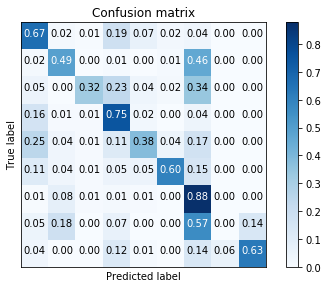

In [13]:
y_predict = xgbclassifier(train_set, train_y, test_set, 10, 8, 1000)

In [14]:
util.savesubmisstion(y_predict, test_x, filename = "submission_allwin2load10fold.csv")